<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-lightning/03-finetuning-with-lightning-flash/02_automatic_speech_recognition_using_flash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Automatic speech recognition using Flash

Recognizing speech from an audio file is perhaps one of the most widely used applications
of AI. It's part of smartphone speakers such as Alexa, as well as automatically generated
captions for video streaming platforms such as YouTube, and also many music platforms.

It can detect speech in an audio file and convert it into text. Detection of speech involves
various challenges such as speaker modalities, pitch, and pronunciation, as well as dialect
and language itself.

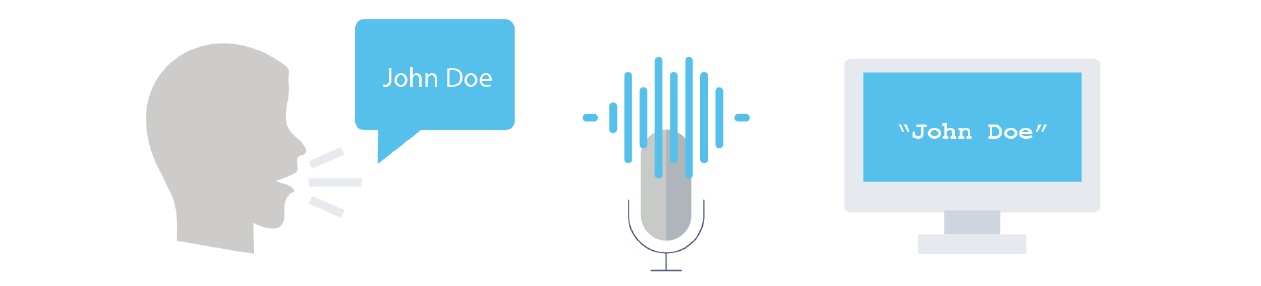

To train a model for Automatic Speech Recognition (ASR), we need a training dataset
that is a collection of audio files along with the corresponding text transcription that
describes that audio. The more diverse the set of audio files with people from different age
groups, ethnicities, dialects, and so on is, the more robust the ASR model will be for the
unseen audio files.

While there are many architectures available for ASR, wav2vec is a really good
cross-lingual architecture developed by Facebook AI. 

It can arguably work on any
language and is extremely scalable. It has recently outperformed the LibriSpeech
benchmark. It was first published in the paper wav2sec: Unsupervised Pre-training
for Speech Recognition.

The wav2vec model is an improvement over the BERT Transformer model, which
we saw in Chapter 3, Using Pre-Trained Models. This model uses much less labeled
data than other models since it relies on "self-supervised learning." It learns the latent
representation of audio files in a set of small speech units (25 ms), which are shorter than
the phenomes. 

These small latent representations are fed into the transformer in masked
form along with knowledge from the entire sequence. A contrastive loss function is used
to find the converge of masked positions and speech units. It uses the concepts of
self-supervision and contrastive loss.

The pre-trained model is trained on nearly 960 hours of audio. The most interesting part
of the architecture is that it is cross-lingual and has been tried in various languages.
We will try this model for a Scottish language dataset.

##Setup

In [ ]:
#install correct version as defined in the Technical Req
!pip install pytorch-lightning --quiet
!pip install lightning-flash --quiet
!pip install 'lightning-flash[audio,image, video, text]' --quiet
!pip install Pillow==9.0.0

In [5]:
import torch
import flash

from flash import Trainer
from flash.audio import SpeechRecognitionData, SpeechRecognition

from sklearn.model_selection import train_test_split

import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import urllib3
urllib3.disable_warnings()

Let's download the Scottish language dataset.

In [ ]:
!wget https://www.openslr.org/resources/83/scottish_english_female.zip
!unzip scottish_english_female.zip

##Dataset

Here, we are collecting the dataset and down-sampling it to use
only 6% of the dataset. This is done because of compute resource limitation. 

If you have
more compute available, you can try a higher number or the entire dataset.

Let's load the dataset.

In [6]:
random.seed(10)

scottish_df = pd.read_csv("line_index.csv", header=None, names=["not_required", "speech_files", "targets"])
scottish_df = scottish_df.sample(frac=0.06)
print(scottish_df.shape)
scottish_df.head()

(54, 3)


,not_required,speech_files,targets
434,EN0514,scf_05223_01907513691,Choose which sounds to hear while you're fall...
159,EN0771,scf_02484_01779494101,He is characterized by his frequent impatienc...
675,EN0228,scf_06136_01207317484,It isn't snowing in Warsaw it is minus eleven...
62,EN0006,scf_05223_00305075751,When a man looks for something beyond his rea...
759,EN0137,scf_05223_00757482258,There are four cities with nonstop flights to...


Now, we will create a train-test split for the dataset.

In [8]:
scottish_df = scottish_df[["speech_files", "targets"]]
scottish_df["speech_files"] = scottish_df["speech_files"].str.lstrip()

scottish_df["speech_files"] = scottish_df["speech_files"].astype(str) + ".wav"
scottish_df.head()

,speech_files,targets
434,scf_05223_01907513691.wav.wav,Choose which sounds to hear while you're fall...
159,scf_02484_01779494101.wav.wav,He is characterized by his frequent impatienc...
675,scf_06136_01207317484.wav.wav,It isn't snowing in Warsaw it is minus eleven...
62,scf_05223_00305075751.wav.wav,When a man looks for something beyond his rea...
759,scf_05223_00757482258.wav.wav,There are four cities with nonstop flights to...


In [9]:
random.seed(10)

train_scottish, test_scottish_raw = train_test_split(scottish_df, test_size=0.2)
test_scottish = test_scottish_raw["speech_files"]
test_scottish.head()

166    scf_06136_01953870538.wav.wav
758    scf_03397_00368900806.wav.wav
590    scf_06136_00954042844.wav.wav
745    scf_02484_00771531634.wav.wav
788    scf_04310_01650377019.wav.wav
Name: speech_files, dtype: object

In [10]:
train_scottish.to_csv("train_scottish.csv")
test_scottish.to_csv("test_scottish.csv")

Now, we are ready to create a data module for this dataset.

In [ ]:
asr_datamodule = SpeechRecognitionData.from_csv("speech_files", "targets", 
                                                train_file="train_scottish.csv", 
                                                predict_file="test_scottish.csv",
                                                batch_size=10)

##Configuring the backbone

The next step for us is now to select the pre-trained model architecture, also called the
"backbone," in Flash.

In [ ]:
# let's list the available model architecture options
print(VideoClassifier.available_backbones())

['c2d_r50', 'csn_r101', 'efficient_x3d_s', 'efficient_x3d_xs', 'i3d_r50', 'r2plus1d_r50', 'slow_r50', 'slow_r50_detection', 'slowfast_16x8_r101_50_50', 'slowfast_r101', 'slowfast_r50', 'slowfast_r50_detection', 'x3d_l', 'x3d_m', 'x3d_s', 'x3d_xs']


In [ ]:
# let's choose the slowfast_r50 model architecture
print(VideoClassifier.get_backbone_details("slowfast_r50"))

[('pretrained', <Parameter "pretrained: bool = False">), ('progress', <Parameter "progress: bool = True">), ('kwargs', <Parameter "**kwargs: Any">)]


Now, it's time for us to create a task using a SlowFast architecture

In [ ]:
slowr50_model = VideoClassifier(backbone="slowfast_r50", labels=kinetics_videodatamodule.labels, pretrained=True)

##Fine-tuning the model

In [ ]:
# Now, we can fine-tune the model
trainer = flash.Trainer(max_epochs=25, gpus=torch.cuda.device_count())
trainer.finetune(slowr50_model, datamodule=kinetics_videodatamodule, strategy="freeze")

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type       | Params
---------------------------------------------
0 | train_metrics | ModuleDict | 0     
1 | val_metrics   | ModuleDict | 0     
2 | test_metrics  | ModuleDict | 0     
3 | backbone      | Net        | 34.6 M
4 | head          | Sequential | 2.0 K 
---------------------------------------------
62.7 K    Trainable params
34.5 M    Non-trainable params
34.6 M    Total params
138.274   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

AssertionError: ignored

##Making predictions

In [ ]:
# let's the model and check the accuracy on the test dataset
trainer.test()

We can observe that we have been able to achieve 60% accuracy on the testing dataset
with just 10 epochs and without any hyperparameter tuning. 

A model improvement
exercise on HealthClaimClassifier might even help us in getting much better
accuracy with the pre-trained BERT model.